In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns             
import datetime
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [2]:
# Source: http://web.mta.info/developers/turnstile.html
# Reading Multiple txt Files and Creating Data Frame
def get_data(week_nums):
    dfs = []
    for week_num in week_nums:
        file="~/mta_turnstile_data/turnstile_"+str(week_num)+".txt"
        dfs.append(pd.read_csv(file))
    return pd.concat(dfs)

week_nums_18 = [180519,180526,180602,180609,180616,180623,180630,180707,180714,180721,180728,180804]
week_nums_19 = [190518,190525,190601,190608,190615,190622,190629,190706,190713,190720,190727,190803]
week_nums_21 = [210515,210522,210529,210605,210612,210619,210626,210703,210710,210717,210724,210731]

df18 = get_data(week_nums_18)#df for year 2018
df19 = get_data(week_nums_19)#df for year 2019
df21 = get_data(week_nums_21)#df for year 2021

In [3]:
# creating function for Data cleaning
def clean_data(df):
    df.columns = df.columns.str.replace(' ', '')
# Eliminate spaces at columns names
    station_mask = (
                (df["STATION"] == "ATLANTIC AV") |
                (df["STATION"] == "FLATBUSH AV-B.C")|
                (df["STATION"] == "ATL AV-BARCLAY")|
                (df["STATION"] == "25 AV")|
                (df["STATION"] == "BERGEN ST")|
                (df["STATION"] == "FULTON ST")|
                (df["STATION"] == "LAFAYETTE AV")
               )
    ss=df[station_mask]
    ss=ss.drop(columns=['LINENAME','DIVISION','DESC']) #droped unwated columns
    ss["TURNSTILE"]=ss[ "C/A"]+ss["UNIT"]+ss["SCP"]+ss["STATION"]
# Adding "TURNSTILE" columns that concatenate 'C/A', 'UNIT', 'SCP','STATION'
    
    return(ss)

In [4]:
df18=clean_data(df18) #calling function for year 2018 dataframe

In [5]:
df19=clean_data(df19) #calling function for year 2019 dataframe

In [6]:
df21=clean_data(df21) #calling function for year 2021 dataframe

In [7]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits

In [8]:
def calculate_daily_entries(df):
    ss = (df.groupby(["TURNSTILE","DATE","STATION"],as_index=False).ENTRIES.first())
    ss[["PREV_DATE", "PREV_ENTRIES"]] = (ss.groupby(["TURNSTILE"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))
    # Drop the rows for the earliest date in the df
    ss.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
    ss["DAILY_ENTRIES"]= ss.apply(get_daily_counts, axis=1, max_counter=100000)
    ss["DATE_TIME"]=pd.to_datetime(ss["DATE"])#Creating DATETIME as"DATE_TIME" column that concatenate "DATE"and"TIME"
    ss["WEEK"]=ss["DATE_TIME"].dt.isocalendar().week
    ss["DAY"]=ss["DATE_TIME"].dt.dayofweek
    MASK=((ss["DAY"] == 0) |
      (ss["DAY"] == 1) |
      (ss["DAY"] == 2) |
      (ss["DAY"] == 3) |
      (ss["DAY"] == 4) 
     )
    ss=ss[MASK]
    VOLUME_PER_STATION=ss.groupby(["WEEK","STATION"])["DAILY_ENTRIES"].sum().reset_index()
    VOLUME_PER_WEEK=ss.groupby(["WEEK"])["DAILY_ENTRIES"].sum().reset_index()
    return(VOLUME_PER_STATION,VOLUME_PER_WEEK)

In [9]:
VOLUME_PER_STATION18,VOLUME_PER_WEEK18=calculate_daily_entries(df18)

/var/folders/w6/39bqqg4n2fgfbdxwjd1r1_rw0000gs/T/ipykernel_955/1660299573.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ss[["PREV_DATE", "PREV_ENTRIES"]] = (ss.groupby(["TURNSTILE"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))


711 3654920.0


In [10]:
VOLUME_PER_STATION19,VOLUME_PER_WEEK19=calculate_daily_entries(df19)

/var/folders/w6/39bqqg4n2fgfbdxwjd1r1_rw0000gs/T/ipykernel_955/1660299573.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ss[["PREV_DATE", "PREV_ENTRIES"]] = (ss.groupby(["TURNSTILE"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))


2254 238251.0
569320813 4807409.0
14 1327005.0
2162762 33622258.0


In [11]:
VOLUME_PER_STATION21,VOLUME_PER_WEEK21=calculate_daily_entries(df21)

/var/folders/w6/39bqqg4n2fgfbdxwjd1r1_rw0000gs/T/ipykernel_955/1660299573.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ss[["PREV_DATE", "PREV_ENTRIES"]] = (ss.groupby(["TURNSTILE"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))


94 765803.0
350 500540.0
327680 786526.0
327680 0.0
432 11851565.0
24 1925928.0
327683 50346231.0


In [12]:
VOLUME_PER_WEEK21["YEAR"]="2021"
VOLUME_PER_STATION21["YEAR"]="2021"

In [13]:
VOLUME_PER_WEEK19["YEAR"]="2019"
VOLUME_PER_STATION19["YEAR"]="2019"

In [14]:
VOLUME_PER_WEEK18["YEAR"]="2018"
VOLUME_PER_STATION18["YEAR"]="2018"

In [15]:
VOLUME_PER_WEEK=pd.concat([VOLUME_PER_WEEK18,VOLUME_PER_WEEK19,VOLUME_PER_WEEK21])

In [16]:
VOLUME_PER_STATION=pd.concat([VOLUME_PER_WEEK18,VOLUME_PER_STATION19,VOLUME_PER_STATION21])

In [17]:
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline 

<Figure size 432x288 with 0 Axes>

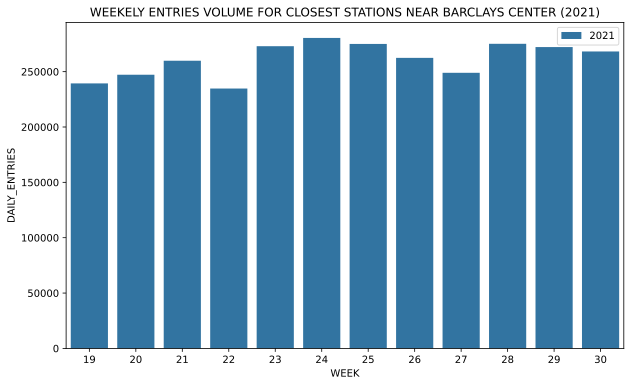

In [22]:
week_barplot=plt.figure()
plt.figure(figsize=(10,6))
plt.title("WEEKELY ENTRIES VOLUME FOR CLOSEST STATIONS NEAR BARCLAYS CENTER (2021)", fontsize=12)
week_barplot=sns.barplot(x='WEEK',y='DAILY_ENTRIES',hue='YEAR',data=VOLUME_PER_WEEK21)
week_barplot.legend(bbox_to_anchor= (1,1))
plt.show()

<Figure size 432x288 with 0 Axes>

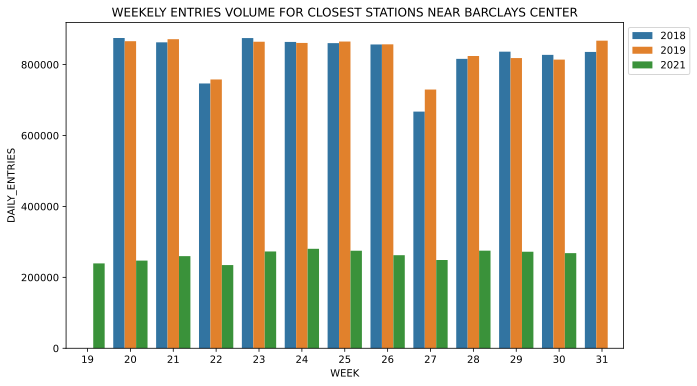

In [21]:
week_barplot=plt.figure()
plt.figure(figsize=(10,6))
plt.title("WEEKELY ENTRIES VOLUME FOR CLOSEST STATIONS NEAR BARCLAYS CENTER", fontsize=12)
week_barplot=sns.barplot(x='WEEK',y='DAILY_ENTRIES',hue='YEAR',data=VOLUME_PER_WEEK)
week_barplot.legend(bbox_to_anchor= (1,1))
plt.show()

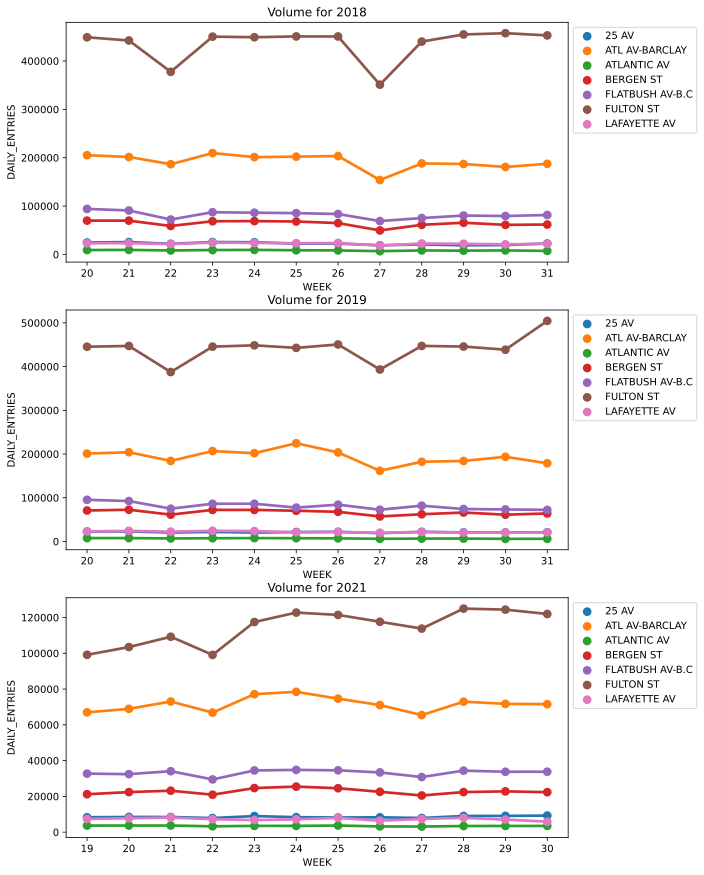

In [19]:
fig = plt.figure(figsize=(9,15))


vol_per_station18 = fig.add_subplot(311)
vol_per_station18.title.set_text("Volume for 2018")
g=sns.pointplot(x='WEEK',y='DAILY_ENTRIES',hue='STATION',kind="point",data=VOLUME_PER_STATION18,ax=vol_per_station18)
g.legend(fontsize=6)
g.legend(bbox_to_anchor= (1,1))


vol_per_station19 = fig.add_subplot(312)
vol_per_station19.title.set_text("Volume for 2019")
g=sns.pointplot(x='WEEK',y='DAILY_ENTRIES',hue='STATION',kind="point",data=VOLUME_PER_STATION19,ax=vol_per_station19)
g.legend(fontsize=6)
g.legend(bbox_to_anchor= (1,1))




vol_per_station21 = fig.add_subplot(313)
vol_per_station21.title.set_text("Volume for 2021")
g=sns.pointplot(x='WEEK',y='DAILY_ENTRIES',hue='STATION',kind="point",data=VOLUME_PER_STATION21,ax=vol_per_station21)
g.legend(bbox_to_anchor= (1,1))


plt.close(2)
plt.close(3)
plt.show()
